In [1]:
import joblib
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sqlite3
import xgboost as xgb

from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

In [3]:
# Load data in memory
def load_data(db_path, query):
    logger.info("Loading data from database...")
    
    conn = sqlite3.connect(db_path)
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    logger.info(f"Data loaded successfully with shape: {df.shape}")
    
    return df

In [4]:
# Preprocess dataset for feature engineering
def preprocess_data(df):
    logger.info("Preprocessing data...")
    
    # Convert data types
    df['imdb_votes'] = df['imdb_votes'].astype('Int64')
    df['year'] = df['year'].astype('Int64')
    df['release_year'] = df['release_year'].astype('Int64')
    df['budget'] = df['budget'].astype('Int64')
    df['revenue'] = df['revenue'].astype('Int64')
    
    # Impute missing values
    df['release_year'] = df['release_year'].fillna(df['year'])
    df['tmdb_vote_average'] = df['tmdb_vote_average'].fillna(df['imdb_rating'])
    df['tmdb_votes'] = df['tmdb_votes'].fillna(df['imdb_votes'])
    
    # Create new features
    df['rating'] = ((df['imdb_rating'] + df['tmdb_vote_average']) / 2).round(1)
    df['votes'] = ((df['imdb_votes'] + df['tmdb_votes'])).astype('Int64')
    
    # Normalize text fields
    for col in ['directors', 'stars', 'genres', 'production_house']:
        df[col] = df[col].str.replace(' ', '_')
    
    # Drop redundant columns
    df.drop(columns=['tmdb_vote_average', 'imdb_rating', 'imdb_votes', 'tmdb_votes', 'year'], inplace=True)
    
    # Drop remaining missing values
    df.dropna(inplace=True)

    # Performing mean imputation for numerical columns
    mean_value = int(df['budget'].replace(0, np.nan).mean())
    df['budget'].replace(0, mean_value, inplace=True)

    mean_value = int(df['revenue'].replace(0, np.nan).mean())
    df['revenue'].replace(0, mean_value, inplace=True)

    logger.info(f"Data preprocessing complete. Shape: {df.shape}")
    return df

In [5]:
# Scale numeric features to keep uniformity of range in between them
def scale_numeric_features(df, columns):
    logger.info("Scaling numeric features...")
    df_scaled = df.copy()
    
    # Replace zeros with NaN and then with median values
    df_scaled[['budget', 'revenue', 'votes']] = df_scaled[['budget', 'revenue', 'votes']].replace(0, np.nan)
    df_scaled[['budget', 'revenue', 'votes']] = df_scaled[['budget', 'revenue', 'votes']].fillna(
        df_scaled[['budget', 'revenue', 'votes']].median()
    )
    
    # Apply log transform to handle skewed distributions
    df_scaled[['budget', 'revenue', 'votes']] = df_scaled[['budget', 'revenue', 'votes']].apply(np.log1p)
    
    # Apply StandardScaler
    scaler = StandardScaler()
    df_scaled[columns] = scaler.fit_transform(df_scaled[columns])
    
    logger.info("Feature scaling complete")
    return df_scaled, scaler

In [6]:
# Get top n items for multivalues attributes
def extract_top_n_items(series, n):
    all_items = series.dropna().str.split(',').sum()
    return [item.strip() for item, _ in Counter(all_items).most_common(n)]

In [7]:
# Get only top n items from multivalued attributes
def filter_items_by_list(text, top_n_list):
    if not isinstance(text, str):
        return ''
    items = [i.strip() for i in text.split(',')]
    return ' '.join([i for i in items if i in top_n_list])

In [8]:
def engineer_features(df):
    logger.info("Engineering features...")
    
    # Extract top items for each categorical feature
    top_genres = extract_top_n_items(df['genres'], 10)
    top_stars = extract_top_n_items(df['stars'], 10)
    top_directors = extract_top_n_items(df['directors'], 5)
    top_producers = extract_top_n_items(df['production_house'], 5)

    # Just for debugging purpose
    logger.info(f"Top genres: {top_genres}")
    logger.info(f"Top stars: {top_stars}")
    logger.info(f"Top directors: {top_directors}")
    logger.info(f"Top producers: {top_producers}")
    
    # Filter data to only include top items
    df['genres_filtered'] = df['genres'].apply(lambda x: filter_items_by_list(x, top_genres))
    df['stars_filtered'] = df['stars'].apply(lambda x: filter_items_by_list(x, top_stars))
    df['directors_filtered'] = df['directors'].apply(lambda x: filter_items_by_list(x, top_directors))
    df['prod_filtered'] = df['production_house'].apply(lambda x: filter_items_by_list(x, top_producers))
    
    # Apply TF-IDF to filtered columns
    def tfidf_to_df(column, prefix):
        vectorizer = TfidfVectorizer(token_pattern=r'(?u)\b[\w.-]+\b')
        tfidf_matrix = vectorizer.fit_transform(df[column])
        feature_names = [f"{prefix}_{feat.replace(' ', '_')}" for feat in vectorizer.get_feature_names_out()]
        return pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
    
    # Generate TF-IDF features
    genre_tfidf = tfidf_to_df('genres_filtered', 'genre')
    star_tfidf = tfidf_to_df('stars_filtered', 'star')
    dir_tfidf = tfidf_to_df('directors_filtered', 'director')
    prod_tfidf = tfidf_to_df('prod_filtered', 'prod')
    
    # Concatenate all features
    result_df = pd.concat([
        df.reset_index(drop=True), 
        genre_tfidf, 
        star_tfidf, 
        dir_tfidf, 
        prod_tfidf
    ], axis=1)
    
    # Drop temporary columns
    columns_to_drop = [
        'genres_filtered', 'stars_filtered', 'directors_filtered', 'prod_filtered',
        'genres', 'stars', 'directors', 'production_house'
    ]
    result_df.drop(columns=columns_to_drop, inplace=True)
    
    logger.info(f"Feature engineering complete. Final shape: {result_df.shape}")
    return result_df

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
# Random Forest Regressor for analysing feature importance
def analyze_feature_importance(df, target_col='rating'):
    logger.info("Analyzing feature importance...")

    # Separate features X from target Y
    X = df.drop(columns=[target_col, 'movieId', 'movie_name', 'language'])
    y = df[target_col]

    # train model
    model = RandomForestRegressor(random_state=42, n_estimators=100)
    model.fit(X, y)
    
    importances = pd.Series(model.feature_importances_, index=X.columns)
    top_features = importances.sort_values(ascending=False).head(20)
    
    logger.info("Feature importance analysis complete")
    return top_features

In [11]:
# Linear Regression code
def train_linear_regression(X_train, X_val, y_train, y_val):
    # Remove non-numeric columns
    X_train = X_train.select_dtypes(include=['number'])
    X_val = X_val.select_dtypes(include=['number'])
    
    # Train model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Evaluate on validation data
    y_pred_val = model.predict(X_val)
    val_mse = mean_squared_error(y_val, y_pred_val)

    logger.info("Linear regression results")
    print(f"\n\nLinear Regression validation MSE: {val_mse:.4f}")
    
    return model, val_mse

In [12]:
# Logisitic Regression code
def train_logistic_regression(X_train, X_val, y_train, y_val):
    # For classification, we need to convert ratings to classes
    y_train_class = (y_train >= 7).astype(int)
    y_val_class = (y_val >= 7).astype(int)
    
    # Remove non-numeric columns
    X_train = X_train.select_dtypes(include=['number'])
    X_val = X_val.select_dtypes(include=['number'])
    
    # Train model
    model = LogisticRegression(
        solver='liblinear',
        C = 1.0,
        class_weight='balanced',
        max_iter=10000
    )
    model.fit(X_train, y_train_class)
    
    # Evaluate on validation data
    y_pred_val = model.predict(X_val)
    val_acc = accuracy_score(y_val_class, y_pred_val)
    val_f1 = f1_score(y_val_class, y_pred_val)
    class_report = classification_report(y_val_class, y_pred_val)

    logger.info("Logistic regression results")
    print(f"\n\nLogistic Regression validation accuracy: {val_acc:.4f}")
    print(f"Logistic Regression validation F1 score: {val_f1:.4f}")
    print("Classification Report:")
    print(class_report)
    
    return model, val_acc, val_f1, class_report

In [13]:
# KNN based recommendation
def build_knn_recommender(df, max_k=30):
    """Build KNN recommender model with optimal k determined by elbow method"""
    print("\nKNN begins")
    # Select features for recommendation
    feature_cols = df.select_dtypes(include=['number']).columns.tolist()
    X_features = df[feature_cols].values
    
    # Use elbow method to determine optimal k
    optimal_k = find_optimal_k(X_features, max_k)
    print(f"\n\nOptimal number of neighbors (k): {optimal_k}")
    
    # Train KNN model with optimal k
    knn_model = NearestNeighbors(n_neighbors=optimal_k, algorithm='auto')
    knn_model.fit(X_features)
    
    return knn_model, X_features, optimal_k

In [14]:
# Determine optimal k value for knn using elbow method
def find_optimal_k(X_features, max_k=30):
    distortions = []
    silhouette_scores = []
    range_k = range(2, max_k + 1)
    
    for k in range_k:
        # Initialize and fit KNN model
        model = NearestNeighbors(n_neighbors=k, algorithm='auto')
        model.fit(X_features)
        
        # Calculate sum of distances (distortion)
        distances, _ = model.kneighbors(X_features)
        distortion = np.sum(distances) / X_features.shape[0]
        distortions.append(distortion)
        
        print(f"Computing for k={k}: distortion={distortion:.4f}")
    
    # Plot elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(range_k, distortions, 'bo-')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Average Distance (Distortion)')
    plt.title('Elbow Method For Optimal k')
    plt.grid(True)
    
    # Save the plot
    if not os.path.exists('figures'):
        os.makedirs('figures')
    plt.savefig('figures/elbow_curve.png')
    plt.close()
    
    # Find the elbow point using the kneedle algorithm
    k_differences = np.diff(distortions, 2)
    elbow_index = np.argmax(k_differences) + 2 if len(k_differences) > 0 else 2
    optimal_k = range_k[elbow_index]
    
    # If elbow detection doesn't work well, default to reasonable value
    if optimal_k <= 2 or optimal_k >= max_k:
        print("Could not detect a clear elbow point, defaulting to k=10")
        optimal_k = 10
    
    return optimal_k

In [15]:
# Get actual rsults for knn based on given input
def get_movie_recommendations(knn_model, X_features, movie_idx, original_df, n_recommendations=10):
    # Ensure we don't ask for more neighbors than the model was trained with
    n_recs = min(n_recommendations, knn_model.get_params()['n_neighbors'])

    # Get Distance simmilariy for results
    distances, indices = knn_model.kneighbors(X_features[movie_idx].reshape(1, -1), n_neighbors=n_recs)
    
    # Get recommendation details
    recommendations = original_df.iloc[indices[0]].copy()
    recommendations['distance'] = distances[0]
    
    # Sort by distance (closer is better)
    recommendations = recommendations.sort_values('distance')
    
    return recommendations[['movie_name', 'rating', 'genres', 'directors', 'distance']]

In [16]:
# Save original datasets used for future reference
def save_datasets(X_train, X_val, X_test, y_train, y_val, y_test, output_dir="data_splits"):
    # If directory does not exist then create one
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Combine features and targets for saving
    train_df = pd.concat([X_train, y_train], axis=1)
    val_df = pd.concat([X_val, y_val], axis=1)
    test_df = pd.concat([X_test, y_test], axis=1)
    
    # Save to CSV
    train_df.to_csv(os.path.join(output_dir, "train_data.csv"), index=False)
    val_df.to_csv(os.path.join(output_dir, "val_data.csv"), index=False)
    test_df.to_csv(os.path.join(output_dir, "test_data.csv"), index=False)

In [17]:
# Save models for future use
def save_models(lin_reg_model, log_reg_model, scaler, output_dir="models"):
    # If directory does not exists then create one
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Save models
    joblib.dump(lin_reg_model, os.path.join(output_dir, "linear_regression_model.pkl"))
    joblib.dump(log_reg_model, os.path.join(output_dir, "logistic_regression_model.pkl"))
    joblib.dump(scaler, os.path.join(output_dir, "feature_scaler.pkl"))
    
    print(f"Models saved to {output_dir}")

In [18]:
# Save knn model along with optimal k value
def save_knn_model(knn_model, optimal_k, output_dir="models"):
    # If directory does not exists then create one
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Save model
    joblib.dump(knn_model, os.path.join(output_dir, "knn_recommender_model.pkl"))
    
    # Save optimal k value for reference
    with open(os.path.join(output_dir, "optimal_k.txt"), "w") as f:
        f.write(str(optimal_k))
    
    print(f"KNN model and optimal k value saved to {output_dir}")

In [19]:
# Train XGBoost classifier
def train_evaluate_xgboost_classifier(X_train, X_test, y_train, y_test, threshold = 7.0):
    # Convert ratings to binary classes first!
    y_train_binary = (y_train >= threshold).astype(int)
    y_test_binary = (y_test >= threshold).astype(int)
    
    # Define parameter grid
    param_grid = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [100, 200]
    }
    
    # Set up grid search
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42
    )
    
    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=3,
        scoring='f1',
        n_jobs=-1
    )
    
    # Train the model with grid search
    grid_search.fit(X_train, y_train_binary)
    
    # Get best model
    best_model = grid_search.best_estimator_
    
    # Make predictions
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]
    
    # Evaluate
    accuracy = accuracy_score(y_test_binary, y_pred)
    f1 = f1_score(y_test_binary, y_pred)
    auc = roc_auc_score(y_test_binary, y_prob)
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    return {
        'model': best_model,
        'best_params': grid_search.best_params_,
        'accuracy': accuracy,
        'f1_score': f1,
        'auc': auc,
        'classification_report': classification_report(y_test_binary, y_pred),
        'confusion_matrix': confusion_matrix(y_test_binary, y_pred),
        'feature_importance': feature_importance,
        'predictions': y_pred,
        'probabilities': y_prob,
        'y_test_binary': y_test_binary
    }

In [20]:
# Main function
def main():
    # Directory paths for saviing models and datasets
    output_dir = 'models'
    plots_dir = 'm2_plots'
    
    # Database query
    db_path = '../Data/movies.db'
    query = """SELECT
        l.movieid,
        i.movie_name,
        i.rating AS imdb_rating,
        i.votes AS imdb_votes,
        i.runtime AS imdb_runtime,
        i.year AS year,
        t.vote_average AS tmdb_vote_average,
        t.vote_count AS tmdb_votes,
        t.original_language as language,
        t.popularity as popularity,
        t.release_year,
        t.budget as budget,
        t.revenue as revenue,
        GROUP_CONCAT(DISTINCT g.genre_name) AS genres,
        GROUP_CONCAT(DISTINCT d.director_name) AS directors,
        GROUP_CONCAT(DISTINCT s.star_name) AS stars,
        GROUP_CONCAT(DISTINCT p.production_companies_name) AS production_house
    FROM links l
    JOIN imdb i ON l.imdbid = i.movie_id
    LEFT JOIN tmdb t ON l.tmdbid = t.id
    LEFT JOIN genre_imdb gi ON i.movie_id = gi.movie_id
    LEFT JOIN genre g ON gi.genre_id = g.genre_id
    LEFT JOIN director_imdb di ON i.movie_id = di.movie_id
    LEFT JOIN director d ON di.director_id = d.director_id
    LEFT JOIN star_imdb si ON i.movie_id = si.movie_id
    LEFT JOIN star s ON si.star_id = s.star_id
    LEFT JOIN production_companies_tmdb pi ON t.id = pi.id
    LEFT JOIN production_companies p ON pi.production_companies_id = p.production_companies_id 
    WHERE language = 'English'
    GROUP BY l.movieid
    """
    
    # Execute pipeline
    df_raw = load_data(db_path, query)
    df_preprocessed = preprocess_data(df_raw)
    
    # Keep original copy for reference
    df_original = df_preprocessed.copy()
    
    # Scale numerical features
    numeric_cols = ['imdb_runtime', 'popularity', 'budget', 'revenue', 'votes']
    df_scaled, scaler = scale_numeric_features(df_preprocessed, numeric_cols)
    
    # Engineer features
    df_final = engineer_features(df_scaled)
    
    # Split data into features and target
    X = df_final.drop('rating', axis=1) if 'rating' in df_final.columns else df_final
    y = df_final['rating'] if 'rating' in df_final.columns else None

    print(X.columns)
    
    # Split data into train, validation, and test sets (60% train, 20% validation, 20% test)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    print(f"Dataset shapes: Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")
    
    # Save datasets to files
    save_datasets(X_train, X_val, X_test, y_train, y_val, y_test)
    
    # Analyze feature importance using only training data
    top_features = analyze_feature_importance(pd.concat([X_train, y_train], axis=1))
    print("Top 20 features by importance:")
    print(top_features)
    
    # Train models using only training data
    lin_reg_model, lin_val_mse = train_linear_regression(X_train, X_val, y_train, y_val)
    log_reg_model, log_val_acc, log_val_f1, class_report = train_logistic_regression(X_train, X_val, y_train, y_val)
    
    knn_model, X_features, optimal_k = build_knn_recommender(df_final)

    # Save trained models
    save_models(lin_reg_model, log_reg_model, scaler)

    # Save trained models - update the save_models function call to include optimal_k
    save_knn_model(knn_model, optimal_k)
    
    # Get recommendations example
    sample_movie_idx = 42
    recommendations = get_movie_recommendations(knn_model, X_features, sample_movie_idx, df_original)
    print("\nSample Recommendations:")
    print(recommendations)

    # Check for any remaining non-numeric columns 
    non_numeric = X_train.select_dtypes(exclude=['int', 'float', 'bool']).columns
    if len(non_numeric) > 0:
        # print(f"Warning: Still have non-numeric columns: {list(non_numeric)}")
        X_train = X_train.drop(non_numeric, axis=1)
        X_test = X_test.drop(non_numeric, axis=1)

    # Train and evaluate XGBoost
    print("\nTraining XGBoost model with grid search...")
    print("This may take a while as we're testing multiple hyperparameter combinations...")
    class_results = train_evaluate_xgboost_classifier(X_train, X_test, y_train, y_test)
    
    # Display classification results
    print("\nClassification Results:")
    print(f"Best Parameters: {class_results['best_params']}")
    print(f"Accuracy: {class_results['accuracy']:.4f}")
    print(f"F1 Score: {class_results['f1_score']:.4f}")
    print(f"AUC: {class_results['auc']:.4f}")
    
    print("\nClassification Report:")
    print(class_results['classification_report'])
    
    print("\nConfusion Matrix:")
    print(class_results['confusion_matrix'])
    
    print("\nTop 10 Features by Importance (Classification):")
    print(class_results['feature_importance'].head(10))
    
    # Save models and results
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    joblib.dump(class_results['model'], os.path.join(output_dir, "xgboost_classifier.pkl"))
    
    class_results['feature_importance'].to_csv(os.path.join(output_dir, "classification_feature_importance.csv"), index=False)

    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(class_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.savefig(os.path.join(plots_dir, "confusion_matrix.png"))
    plt.show()
    
    # Plot ROC curve
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(class_results['y_test_binary'], class_results['probabilities'])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, lw=2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (AUC = {class_results["auc"]:.4f})')
    plt.savefig(os.path.join(plots_dir, "roc_curve.png"))
    plt.show()
    
    print("\n"+"="*80)
    print("Training and evaluation complete!")
    print(f"All results saved to {output_dir}")
    print("="*80)
    
    return class_results

2025-04-23 07:36:15,375 - INFO - Loading data from database...
2025-04-23 07:36:18,701 - INFO - Data loaded successfully with shape: (28508, 17)
2025-04-23 07:36:18,701 - INFO - Preprocessing data...
2025-04-23 07:36:18,724 - INFO - Data preprocessing complete. Shape: (28505, 14)
2025-04-23 07:36:18,726 - INFO - Scaling numeric features...
2025-04-23 07:36:18,733 - INFO - Feature scaling complete
2025-04-23 07:36:18,733 - INFO - Engineering features...
2025-04-23 07:36:27,703 - INFO - Top genres: ['Drama', 'Comedy', 'Romance', 'Thriller', 'Horror', 'Crime', 'Action', 'Adventure', 'Mystery', 'Sci-Fi']
2025-04-23 07:36:27,703 - INFO - Top stars: ['Nicolas_Cage', 'Bruce_Willis', 'Eric_Roberts', 'John_Wayne', 'Michael_Caine', 'Robert_De_Niro', 'James_Mason', 'Samuel_L._Jackson', 'Christopher_Lee', 'Boris_Karloff']
2025-04-23 07:36:27,704 - INFO - Top directors: ['Michael_Curtiz', 'Richard_Thorpe', 'Alfred_Hitchcock', 'Mervyn_LeRoy', 'Raoul_Walsh']
2025-04-23 07:36:27,704 - INFO - Top produ

Index(['movieId', 'movie_name', 'imdb_runtime', 'language', 'popularity',
       'release_year', 'budget', 'revenue', 'votes', 'genre_action',
       'genre_adventure', 'genre_comedy', 'genre_crime', 'genre_drama',
       'genre_horror', 'genre_mystery', 'genre_romance', 'genre_sci-fi',
       'genre_thriller', 'star_boris_karloff', 'star_bruce_willis',
       'star_christopher_lee', 'star_eric_roberts', 'star_james_mason',
       'star_john_wayne', 'star_michael_caine', 'star_nicolas_cage',
       'star_robert_de_niro', 'star_samuel_l._jackson',
       'director_alfred_hitchcock', 'director_mervyn_leroy',
       'director_michael_curtiz', 'director_raoul_walsh',
       'director_richard_thorpe', 'prod_20th_century_fox',
       'prod_metro-goldwyn-mayer', 'prod_paramount', 'prod_unknown',
       'prod_warner_bros._pictures'],
      dtype='object')
Dataset shapes: Train: (17103, 39), Validation: (5701, 39), Test: (5701, 39)


2025-04-23 07:36:28,053 - INFO - Analyzing feature importance...
2025-04-23 07:36:33,611 - INFO - Feature importance analysis complete
2025-04-23 07:36:33,629 - INFO - Linear regression results
2025-04-23 07:36:33,660 - INFO - Logistic regression results


Top 20 features by importance:
votes                       0.362600
release_year                0.186089
popularity                  0.106943
imdb_runtime                0.092743
genre_drama                 0.076178
genre_horror                0.027125
budget                      0.024619
genre_sci-fi                0.019077
genre_action                0.016822
genre_comedy                0.014279
revenue                     0.012942
genre_adventure             0.012143
genre_thriller              0.010233
genre_crime                 0.009145
genre_romance               0.007823
prod_unknown                0.007052
genre_mystery               0.006238
prod_metro-goldwyn-mayer    0.001547
prod_20th_century_fox       0.001222
prod_paramount              0.001190
dtype: float64


Linear Regression validation MSE: 0.6739


Logistic Regression validation accuracy: 0.7588
Logistic Regression validation F1 score: 0.4141
Classification Report:
              precision    recall  f1-score   supp

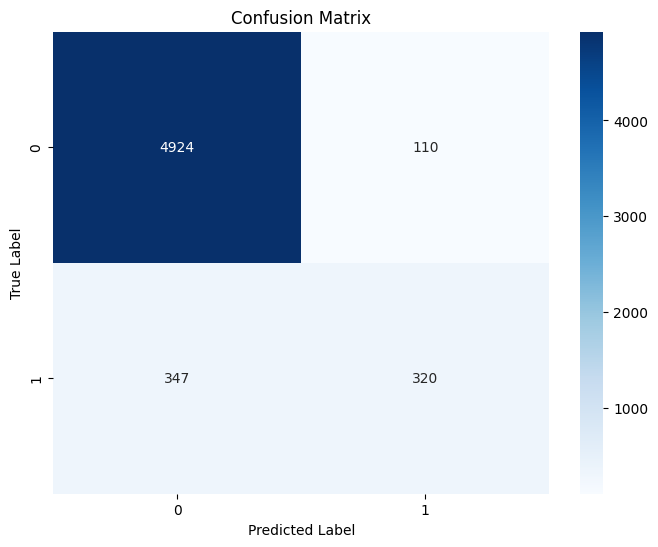

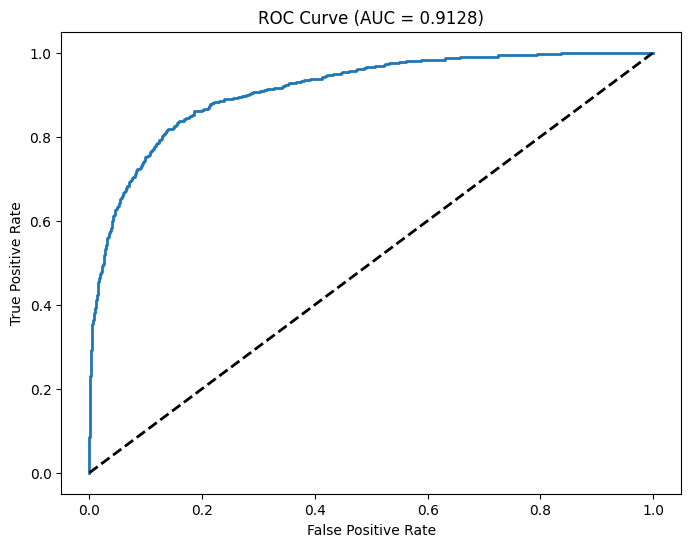


Training and evaluation complete!
All results saved to models


In [21]:
if __name__ == "__main__":
    main()